# Demonstration

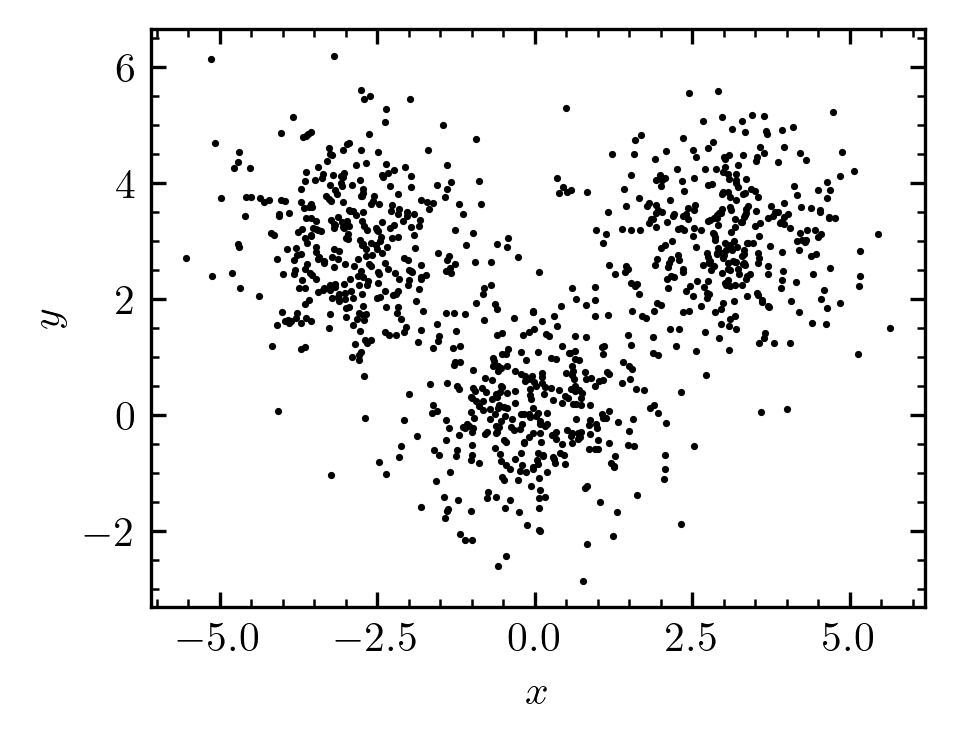

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
X = np.random.multivariate_normal(np.zeros(2), np.eye(2), size=1000)
X[::3] += [-3, +3]
X[1::3] += [+3, +3]
plt.scatter(X[:, 0], X[:, 1], s=3, color='black', lw=0)
plt.xlabel('$x$')
plt.ylabel('$y$');

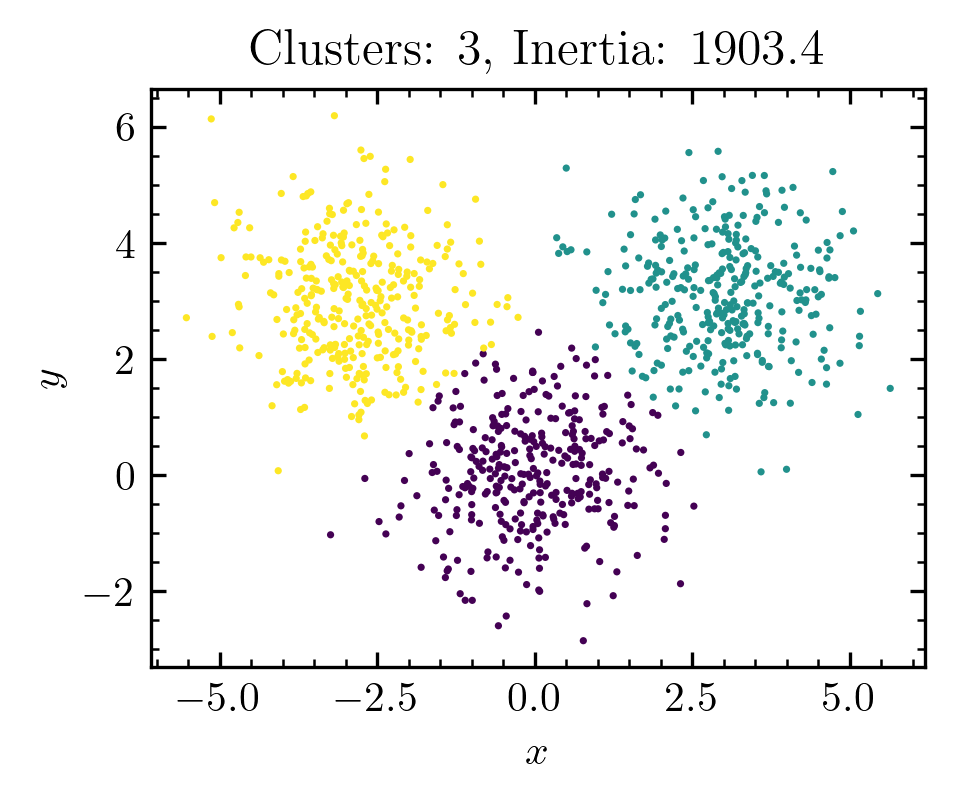

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans

np.random.seed(42)
X = np.random.multivariate_normal(np.zeros(2), np.eye(2), size=1000)
X[::3] += [-3, +3]
X[1::3] += [+3, +3]

kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
c = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], s=3, c=c, lw=0)
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.title(f'Clusters: {len(kmeans.cluster_centers_)}, ' +
          f'Inertia: {kmeans.inertia_:.1f}')

inertia = 0
for i, center in enumerate(kmeans.cluster_centers_):
    inertia += np.linalg.norm(center - X[c == i])**2

assert np.isclose(inertia, kmeans.inertia_)

# Exercise

In this exercise, we will analyze the [Global database of Coastal Characteristics (GCC)](https://zenodo.org/records/11072020). Please follow the link and download the file `GCC_geophysical.csv`. This file contains geophysical information on $\sim 730,000$ $1$-km coastal strips along the global ice-free coastline. The paper describing the database can be found [here](https://essd.copernicus.org/articles/16/3433/2024/). Coincidentally, the authors of the study demonstrate their dataset using a K-means clustering analysis.

(a) Load the data using pandas and plot a map of the data points. You can use the `show` function I provide below.

As in the study, use the following six geophysical indicators from the database for our analysis:

    1. coastal max (`z_peak_max_1km_copdem`)
    2. Mean hinterland elevation (`he`)
    3. nearshore slope (`ns`)
    4. backshore slope (`bs_deltadtm`)
    5. open-water land cover class occurrence (`lu_water`)
    6. transition zone width (`tr_zone_width`)

(b) Filter out rows without valid entries for the above six indicators. Next, perform a quantile transformation of the data points. This transformation replaces all features with the rank of each feature in the dataset. This is implemented in `sklearn.preprocessing.QuantileTransformer`.

(c) Use the transformed, $6$-dimensional data points from part (b) to perform a K-mean clustering analysis. Use $9$ clusters as in the paper and visualize the result using the `show` function. What do you see?

(d) Make an "elbow" plot, i.e., show the inertia as a function of the number of clusters. How many clusters would you choose for this dataset and why?

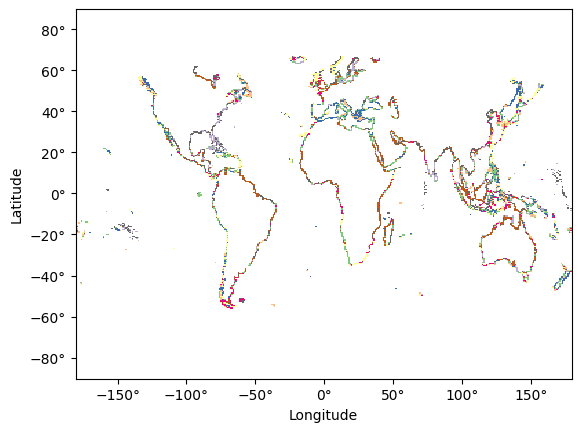

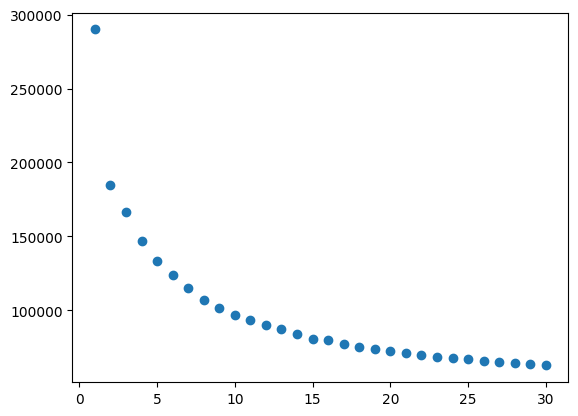

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import StrMethodFormatter
from scipy.spatial import cKDTree
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans

def show(lon, lat, c=None, n_pix=360):
    """Show the clusters on a map.

    The function will produce a plot of the globe where each pixel is colored
    according to the most common cluster label within each pixel.

    Parameters
    ----------
    lon : array_like
        Longitude.
    lat : array_like
        Latitude.
    c : array_like, optional
        Cluster label. If None, all points are assumed to have the same label.
        Default is None.
    n_pix : int
        How many pixels to use per longitude and latitude dimension. Default is
        360.
    """

    if c is None:
        c = np.zeros(len(lon), dtype=int)
    lon_grid = np.linspace(0, 360, n_pix, endpoint=False)
    lat_grid = np.linspace(0, 180, n_pix, endpoint=False)
    lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)
    n_grid = len(lon_grid.ravel())
    tree = cKDTree(np.column_stack([lon_grid.ravel(), lat_grid.ravel()]),
                   boxsize=[360 + 1e-6, 1e99])
    
    idx = tree.query(np.column_stack([lon + 180, lat + 90]))[1]
    # Count occurrence per unique label.
    counts = np.zeros((n_grid, len(np.unique(c))))
    for i, c_i in enumerate(np.unique(c)):
        counts[:, i] = np.bincount(idx, weights=(c == c_i), minlength=n_grid)
    # Find the most common label in each grid point.
    c_grid = np.where(
        np.sum(counts, axis=1) > 0, np.argmax(counts, axis=1), np.nan)
    plt.pcolormesh(lon_grid - 180, lat_grid - 90,
                   c_grid.reshape(lat_grid.shape), cmap='Accent')
    plt.xlabel(r'Longitude')
    plt.ylabel(r'Latitude')
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))
    plt.show()

df = pd.read_csv('GCC_geophysical.csv', delimiter=',')
longitude = df['lon']
latitude = df['lat']

# a) show data points
def show_data_points():
    show(longitude, latitude)

# b) filter out NaN
filtered_df = df.dropna(subset=['z_peak_max_1km_copdem', 'he', 'ns', 'bs_deltadtm', 'lu_water', 'tr_zone_width'])
longitude = filtered_df['lon']
latitude = filtered_df['lat']

# b) create and transform X
qt = QuantileTransformer()
X = filtered_df[['z_peak_max_1km_copdem', 'he', 'ns', 'bs_deltadtm', 'lu_water', 'tr_zone_width']]
X = qt.fit_transform(X)

# c) cluster analysis
kmeans = KMeans(n_clusters=9).fit(X)
c = kmeans.predict(X)
show(longitude, latitude, c)

# d) elbow plot
cluster_n = range(1, 31)
inertia_list = []
for n in cluster_n:
    kmeans = KMeans(n_clusters=n).fit(X)
    inertia_list.append(kmeans.inertia_)
plt.title('Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.scatter(cluster_n, inertia_list)

# show_data_points()